In [5]:
import model_utils
import pandas as pd

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")

In [10]:
import pandas as pd
merged_demand = pd.read_parquet("preprocessed_demand_with_energy.parquet")

Train model on wind and energy data at once

In [ ]:
import model_utils
import pandas as pd

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")

columns_to_add = list()

for col in merged_hornsea.columns:
    if col not in merged_pes.columns:
        columns_to_add.append(col)

merged_all = merged_pes.merge(merged_hornsea[columns_to_add], left_index = True, right_index = True)
merged_all["energy"] = merged_all["Solar_MWh_credit"] + merged_all["Wind_MWh_credit"]
merged_all.drop(["Solar_MWh_credit", "Wind_MWh_credit"], axis = 1, inplace = True)

from Preprocessing import *
feature_engineerer_all = FeatureEngineerer(labels_to_remove=  ["energy"], columns_to_ohe = ['unavailabilityType', 'affectedUnit'], label = ["energy"])
feature_engineerer_all.perform_feature_engineering(merged_all, deployment = False, labels_to_remove=  ["energy"])

import numpy as np
quantiles = np.arange(0.1, 1.0, 0.1).round(2)

# Specify model save directory
model_save_dir_qr = "lgbm_mode"

lgbm_model = model_utils.LGBMRegressorModel(feature_engineerer_all, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
lgbm_model.train_and_predict()  # This will skip training for already loaded models

def pinball_score(self):
        """pinball score implemetation"""

        score = []
        try:
            df = pd.DataFrame(self.q_predictions)
        except:
            df = pd.DataFrame()
            for k in self.q_predictions.keys():
                df[k] = pd.DataFrame(self.q_predictions[k])
        for qu in self.quantiles:
            score.append(self.pinball(y=df["true"], q=df[str(qu)], alpha=qu).mean())
        return sum(score) / len(score)

print(pinball_score(lgbm_model))
# import plotly.express as px
# df.index = feature_engineerer_all.y_test.index
# px.line(df, y = ["true", "0.5"])

In [1]:
from Preprocessing import * 

prep = Preprocessing()

merged_hornsea = prep.perform_preprocessing_pipeline(geo_data_dict = {"dwd_icon_eu_hornsea":"nc_files", "ncep_gfs_hornsea":"nc_files"},
                                              deployment = False, merge_with_outage_data = True, json_file_path = "nc_files/REMIT", energy_data_dict = {"Energy_data":"csv_files"},
                                              non_numerical_columns = ["unavailabilityType", "affectedUnit"],
                                              fft = False,
                                              #columns_to_fft = ["temp_diff", "solar_down_rad_diff", "wind_dir_sin", "wind_dir_cos", "wind_dir_100_sin", "wind_dir_100_cos"]
                                              )

merged_pes = prep.perform_preprocessing_pipeline(geo_data_dict = {"dwd_icon_eu_pes":"nc_files", "ncep_gfs_pes":"nc_files"},
          deployment = False, merge_with_outage_data = False, energy_data_dict = {"Energy_data":"csv_files"},
                                              non_numerical_columns = ["unavailabilityType", "affectedUnit"],
                                              fft = False, ) 

merged_demand = prep.perform_preprocessing_pipeline(geo_data_dict = {"dwd_icon_eu_demand":"nc_files", "ncep_gfs_demand":"nc_files"},
          deployment = False, merge_with_outage_data = True, energy_data_dict = {"Energy_data":"csv_files"},
                                              non_numerical_columns = ["unavailabilityType", "affectedUnit"],
                                              fft = False, )

INFO:root:Perform data cleaning on the weather data...
INFO:root:Merge weather stations...
INFO:root:Merge with outages data (REMIT)...
c:\Users\danie\Documents\AWP2_Repo\awp2\Preprocessing.py:329: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  outages_df = pd.concat([outages_df, json_data_with_date_ranges])
c:\Users\danie\Documents\AWP2_Repo\awp2\Preprocessing.py:329: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outages_df = pd.concat([outages_df, json_data_with_date_ranges])
INFO:root:Merge with energy data...
INFO:root:Pr

In [7]:
merged_hornsea.to_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes.to_parquet("preprocessed_pes_with_energy.parquet")
merged_demand.to_parquet("preprocessed_demand_with_energy.parquet")

In [2]:
import importlib
import Preprocessing
importlib.reload(Preprocessing)
import model_utils
import pandas as pd

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")

feature_engineerer_wind = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe = ['unavailabilityType', 'affectedUnit'])
feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

feature_engineerer_solar = Preprocessing.FeatureEngineerer(label = "Solar_MWh_credit")
feature_engineerer_solar.perform_feature_engineering(merged_pes, deployment = False)

merged_pes_simple = merged_pes[['solar_down_rad', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_solar_baseline = Preprocessing.FeatureEngineerer(label = 'Solar_MWh_credit')
feature_engineerer_solar_baseline.perform_feature_engineering(merged_pes_simple, deployment = False)

merged_hornsea_simple = merged_hornsea[['wind_speed_100', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_wind_baseline = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit')
feature_engineerer_wind_baseline.perform_feature_engineering(merged_hornsea_simple, deployment = False)

### __Wind Energy Forecast__

__baseline__

In [ ]:
import model_utils
import numpy as np
import importlib
importlib.reload(model_utils)

quantiles = np.arange(0.1, 1.0, 0.1).round(2)

# Specify model save directory
model_save_dir_qr = "qr_model_wind"

qr_model_wind = model_utils.QuantileRegressorModel(feature_engineerer_wind_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
qr_model_wind.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_wind.pinball_score()}")

In [ ]:
qr_model_wind.plot_quantils(feature_engineerer_wind_baseline.y_test.index, qr_model_wind.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1), year=2023)

__xgboost__

In [ ]:
importlib.reload(model_utils)
import numpy as np

quantiles = np.arange(0.1, 1.0, 0.1)

model_save_dir_xgboost = "xgboost_model_wind"
hyperparams = {
            # Use the quantile objective function.
            "objective": "reg:quantileerror",
            "tree_method": "hist",
            "quantile_alpha": quantiles,
            "learning_rate": 0.01,
            "max_depth": 8
        }

xgboost_model_wind = model_utils.XGBoostModel(feature_engineerer_wind, quantiles=quantiles, model_save_dir=model_save_dir_xgboost, load_pretrained=False, hyperparams=hyperparams, num_boost_round=45, early_stopping_rounds=10)
xgboost_model_wind.train_and_predict()  # This will skip training if the model is already loaded
print(f"XGBoost Pinball Score: {xgboost_model_wind.pinball_score()}")

In [ ]:
xgboost_model_wind.plot_feature_importance()

In [ ]:
xgboost_model_wind.plot_quantils(daterange=feature_engineerer_wind.y_test.index, y=xgboost_model_wind.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1), year=2023)

### __Solar Energy Forecast__

__baseline modell__

In [ ]:
quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "qr_model_solar"

qr_model_solar = model_utils.QuantileRegressorModel(feature_engineerer_solar_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
qr_model_solar.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_solar.pinball_score()}")

In [ ]:
qr_model_solar.plot_quantils(daterange=feature_engineerer_solar_baseline.y_test.index, y=qr_model_solar.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1), year=2023)

__xgboost__

In [ ]:
quantiles = np.arange(0.1, 1.0, 0.1)

model_save_dir_xgboost = "xgboost_model_solar"

xgboost_model_solar = model_utils.XGBoostModel(feature_engineerer_solar, quantiles=quantiles, model_save_dir=model_save_dir_xgboost, load_pretrained=False)
xgboost_model_solar.train_and_predict()  # This will skip training if the model is already loaded
print(f"XGBoost Pinball Score: {xgboost_model_solar.pinball_score()}")

In [ ]:
xgboost_model_solar.plot_feature_importance()

In [ ]:
xgboost_model_solar.plot_quantils(daterange=feature_engineerer_solar.y_test.index, y=xgboost_model_solar.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1), year=2023, month = 7, day = 10)

### __Lightgbm implementation__

In [14]:
importlib.reload(model_utils)
import numpy as np
quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_wind"

lgbm_model_wind = model_utils.LGBMRegressorModel(feature_engineerer_wind, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
lgbm_model_wind.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_wind.pinball_score()}")

[LightGBM] [Info] Total Bins 14479
[LightGBM] [Info] Number of data points in the train set: 39984, number of used features: 74
[LightGBM] [Info] Start training from score 9.086801
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 10.1207	valid's quantile: 10.9699
[100]	train's quantile: 9.33063	valid's quantile: 10.9081
Early stopping, best iteration is:
[78]	train's quantile: 9.49369	valid's quantile: 10.8761
Saved Quantile Regressor model for quantile 0.1 to lgbm_model_wind\lgbm_model_quantile_0.1.pkl
[LightGBM] [Info] Total Bins 14479
[LightGBM] [Info] Number of data points in the train set: 39984, number of used features: 74
[LightGBM] [Info] Start training from score 43.821404
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 14.4102	valid's quantile: 17.3024
[100]	train's quantile: 13.4749	valid's quantile: 17.2526
Early stopping, best iteration is:
[75]	train's quantile: 13.8839	valid's quantile: 17.2107
Saved 

In [20]:
importlib.reload(model_utils)
import numpy as np
quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_wind_hp"

for q in np.arange(0.1, 1.0, 0.1).round(2):
    params = {
                    "alpha":[q],
                    'boosting': ["gbdt", "dart"],
                    "force_col_wise": [True],
                    "num_leaves": [20, 40],
                    "max_depth": [3, 5, 10],
                    'learning_rate': [0.001, 0.01, 0.1],
                    "n_estimators": [250, 500],
                    'objective': ['quantile'],
                    "min_data_in_leaf":[200, 300, 500],
                    "random_state": [42],
                    "verbose":[-1],
                    "extra_trees":[False],
                }
    lgbm_model_wind_hp = model_utils.LGBMRegressorModel(feature_engineerer_wind, quantiles = [q], model_save_dir=model_save_dir_qr, load_pretrained=False)
    lgbm_model_wind_hp.train_and_predict_hyperparametertuning(parameters=params)  # This will skip training for already loaded models
    print(f"Quantile Regressor Pinball Score: {lgbm_model_wind_hp.pinball_score()}")

--------Train model for Quantile 0.1: 


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


In [ ]:
lgbm_model_wind.plot_quantils(feature_engineerer_wind.y_test.index, lgbm_model_wind.q_predictions, quantiles, year = 2023, month=7)

In [ ]:
quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_solar"

lgbm_model_solar = model_utils.LGBMRegressorModel(feature_engineerer_solar, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
lgbm_model_solar.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_solar.pinball_score()}")

In [ ]:
lgbm_model_solar.plot_quantils(feature_engineerer_solar.y_test.index, lgbm_model_solar.q_predictions, quantiles, year=2023, month=6, day=19)

### LSTM

In [4]:
import torch.nn
import neural_networks
from neural_networks import *

import Preprocessing

import model_utils
import pandas as pd

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")

feature_engineerer_wind = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe = ['unavailabilityType', 'affectedUnit'])
feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

class LSTM_model(neural_networks.q_model):
    def __init__(self, quantiles= np.arange(0.1, 1.0, 0.1).round(2), 
                 in_shape=50,  
                 dropout=0.5,
                 len_features=66):
        super().__init__(quantiles = quantiles, in_shape = in_shape, dropout = dropout, len_features = len_features)

    def build_model(self):

        self.lstm1 = nn.LSTM(self.len_features, 20, dropout=0.3,  num_layers = 2, batch_first=True)
        self.activation = nn.ReLU()
        # Final layers for quantiles
        final_layers = [
            nn.Linear(20, 1) for _ in range(len(self.quantiles))
        ]
        self.final_layers = nn.ModuleList(final_layers)

    def forward(self, x):
        # x is of shape (batch_size, seq_len, len_features)
        # LSTM layers - extracting the output (not hidden and cell states)
        out, _ = self.lstm1(x)
        # Apply final layers to get quantile outputs
        quantile_outputs = [layer(out) for layer in self.final_layers]
        
        return torch.cat(quantile_outputs, dim=-1)
    
    def init_weights(self): 
        for m in chain(self.final_layers):
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight)
                nn.init.constant_(m.bias, 0)   

quantiles = np.arange(0.1, 1.0, 0.1)

lstm_wind = neural_networks.Trainer(feature_engineerer_wind,  LSTM_model,quantiles, lr = 0.01, batch_size = 32)
lstm_wind.train_and_test()

0. epoche startet: 
1. epoche startet: 
2. epoche startet: 
3. epoche startet: 
4. epoche startet: 
5. epoche startet: 
6. epoche startet: 
7. epoche startet: 
8. epoche startet: 
9. epoche startet: 
Epoch 10: 736.8152465820312
10. epoche startet: 
11. epoche startet: 
12. epoche startet: 
13. epoche startet: 
14. epoche startet: 
15. epoche startet: 
16. epoche startet: 
17. epoche startet: 
18. epoche startet: 
19. epoche startet: 
Epoch 20: 402.4713439941406
20. epoche startet: 
21. epoche startet: 
22. epoche startet: 
23. epoche startet: 
24. epoche startet: 
25. epoche startet: 
26. epoche startet: 
27. epoche startet: 
28. epoche startet: 
29. epoche startet: 
Epoch 30: 205.65716552734375
30. epoche startet: 
31. epoche startet: 
32. epoche startet: 
33. epoche startet: 
34. epoche startet: 
35. epoche startet: 
36. epoche startet: 
37. epoche startet: 
38. epoche startet: 
39. epoche startet: 
Epoch 40: 152.38055419921875
40. epoche startet: 
41. epoche startet: 
42. epoche sta

AttributeError: module 'model_utils' has no attribute 'pinball_score_nn'

In [7]:
def save_pytorch_model(model, model_name):
    torch.save(model.state_dict(), f"{model_name}")

def load_pytorch_model(class_name, model_name, len_features, quantiles = np.arange(0.1, 1.0, 0.1).round(2)):
    model = class_name(quantiles = quantiles, len_features = len_features)
    model.load_state_dict(torch.load(f"{model_name}", weights_only=True))

save_pytorch_model(lstm_wind.model, "LSTM_wind")
load_pytorch_model(LSTM_model, "LSTM_wind", feature_engineerer_wind.X_train.shape[1])

In [119]:
lstm_wind.model.predict()

AttributeError: 'LSTM_model' object has no attribute 'predict'

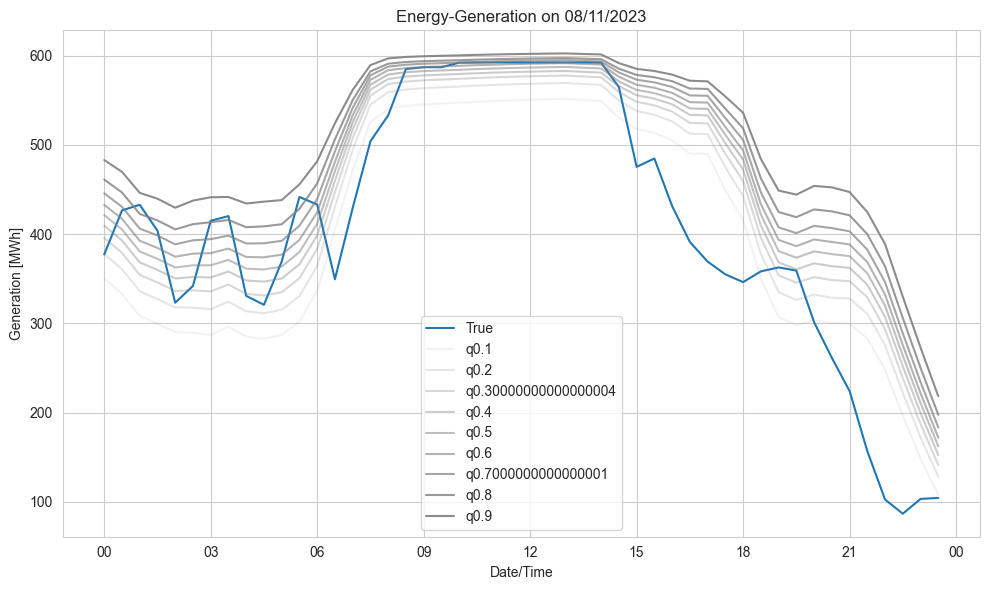

In [8]:
lstm_wind.plot_quantils(feature_engineerer_wind.y_test.index, nn_wind.q_prediction_nn, quantiles, year = 2023, month = 11, day = 8)

In [10]:
import importlib
import Preprocessing
importlib.reload(Preprocessing)

import model_utils
import pandas as pd

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")

feature_engineerer_wind = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe = ['unavailabilityType', 'affectedUnit'])
feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

feature_engineerer_solar = Preprocessing.FeatureEngineerer(label = "Solar_MWh_credit")
feature_engineerer_solar.perform_feature_engineering(merged_pes, deployment = False)

merged_pes_simple = merged_pes[['solar_down_rad', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_solar_baseline = Preprocessing.FeatureEngineerer(label = 'Solar_MWh_credit')
feature_engineerer_solar_baseline.perform_feature_engineering(merged_pes_simple, deployment = False)

merged_hornsea_simple = merged_hornsea[['wind_speed_100', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_wind_baseline = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit')
feature_engineerer_wind_baseline.perform_feature_engineering(merged_hornsea_simple, deployment = False)

import neural_networks
import numpy as np
importlib.reload(neural_networks)
from functools import partial
from itertools import chain
import torch
import torch.nn as nn
quantiles = np.arange(0.1, 1.0, 0.1)

nn_wind = neural_networks.Trainer(feature_engineerer_wind, neural_networks.q_model,quantiles)
nn_wind.train_and_test()

c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0. epoche startet: 
1. epoche startet: 
2. epoche startet: 
3. epoche startet: 
4. epoche startet: 


KeyboardInterrupt: 

In [ ]:
import neural_networks
importlib.reload(neural_networks)
from functools import partial
from itertools import chain
import torch
import torch.nn as nn
quantiles = np.arange(0.1, 1.0, 0.1)

nn_solar = neural_networks.Trainer(feature_engineerer_solar, neural_networks.q_model, quantiles, in_shape=30)
nn_solar.train_and_test()

In [ ]:
nn_solar.plot_quantils(feature_engineerer_solar.y_test.index, nn_solar.q_prediction_nn, quantiles, day=8)

In [1]:
import importlib
import Preprocessing
importlib.reload(Preprocessing)

import model_utils
import pandas as pd

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")

feature_engineerer_wind = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe = ['unavailabilityType', 'affectedUnit'])
feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

feature_engineerer_solar = Preprocessing.FeatureEngineerer(label = "Solar_MWh_credit")
feature_engineerer_solar.perform_feature_engineering(merged_pes, deployment = False)

merged_pes_simple = merged_pes[['solar_down_rad', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_solar_baseline = Preprocessing.FeatureEngineerer(label = 'Solar_MWh_credit')
feature_engineerer_solar_baseline.perform_feature_engineering(merged_pes_simple, deployment = False)

merged_hornsea_simple = merged_hornsea[['wind_speed_100', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_wind_baseline = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit')
feature_engineerer_wind_baseline.perform_feature_engineering(merged_hornsea_simple, deployment = False)

In [3]:
from neural_networks import *
# source: https://github.com/TheQuantScientist/CNN-LSTM-AM/blob/main/src/CLAM.ipynb
cnn_lstm = CNN_LSTM(feature_engineerer = feature_engineerer_wind, forecast_length = 1, sequence_length = 1, cnn_filters = 100, lstm_layers = 50)
cnn_lstm.fit_models(model_name = "CNN_LSTM_wind_1CNN1LSTM", model_save_dir = "CNN_LSTM", verbose = 1, batch_size = 16, epochs = 40, lr = 0.01)

# Evaluate the model


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\pytorch_forecasting\models\base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Epoch 1/40
 292/2499 [==>...........................] - ETA: 2s - loss: 28.1565 - <lambda>: 28.1565

KeyboardInterrupt: 

In [6]:
cnn_lstm_solar = CNN_LSTM(feature_engineerer = feature_engineerer_solar, forecast_length = 1, sequence_length = 1, cnn_filters = 64, lstm_layers = 30)
cnn_lstm_solar.fit_models(model_name = "CNN_LSTM_solar", model_save_dir = "CNN_LSTM", verbose = 1, batch_size = 64, epochs = 40, lr = 0.01)

Epoch 1/40
625/625 [==============================] - 3s 2ms/step - loss: 10.5401 - <lambda>: 10.5401 - val_loss: 12.9076 - val_<lambda>: 12.9076 - lr: 0.0010
Epoch 2/40
625/625 [==============================] - 1s 2ms/step - loss: 9.9743 - <lambda>: 9.9743 - val_loss: 12.4173 - val_<lambda>: 12.4173 - lr: 0.0010
Epoch 3/40
625/625 [==============================] - 1s 2ms/step - loss: 9.5987 - <lambda>: 9.5987 - val_loss: 12.0156 - val_<lambda>: 12.0156 - lr: 0.0010
Epoch 4/40
625/625 [==============================] - 1s 2ms/step - loss: 9.2760 - <lambda>: 9.2760 - val_loss: 11.6237 - val_<lambda>: 11.6237 - lr: 0.0010
Epoch 5/40
625/625 [==============================] - 1s 2ms/step - loss: 8.9741 - <lambda>: 8.9741 - val_loss: 11.3587 - val_<lambda>: 11.3587 - lr: 0.0010
Epoch 6/40
625/625 [==============================] - 1s 2ms/step - loss: 8.7084 - <lambda>: 8.7084 - val_loss: 11.0505 - val_<lambda>: 11.0505 - lr: 0.0010
Epoch 7/40
625/625 [==============================] - 1s

c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:root:Saved model at CNN_LSTM/CNN_LSTM_solar_quantile_0.1.h5


Epoch 1/40
625/625 [==============================] - 3s 2ms/step - loss: 21.0256 - <lambda>: 21.0256 - val_loss: 25.7312 - val_<lambda>: 25.7312 - lr: 0.0010
Epoch 2/40
625/625 [==============================] - 1s 2ms/step - loss: 19.8346 - <lambda>: 19.8346 - val_loss: 24.6666 - val_<lambda>: 24.6666 - lr: 0.0010
Epoch 3/40
625/625 [==============================] - 1s 2ms/step - loss: 18.9768 - <lambda>: 18.9768 - val_loss: 23.7509 - val_<lambda>: 23.7509 - lr: 0.0010
Epoch 4/40
625/625 [==============================] - 1s 2ms/step - loss: 18.2222 - <lambda>: 18.2222 - val_loss: 22.9152 - val_<lambda>: 22.9152 - lr: 0.0010
Epoch 5/40
625/625 [==============================] - 1s 2ms/step - loss: 17.5379 - <lambda>: 17.5379 - val_loss: 22.1128 - val_<lambda>: 22.1128 - lr: 0.0010
Epoch 6/40
625/625 [==============================] - 1s 2ms/step - loss: 16.8974 - <lambda>: 16.8974 - val_loss: 21.4922 - val_<lambda>: 21.4922 - lr: 0.0010
Epoch 7/40
625/625 [==========================

INFO:root:Saved model at CNN_LSTM/CNN_LSTM_solar_quantile_0.2.h5


Epoch 1/40
625/625 [==============================] - 4s 3ms/step - loss: 31.4234 - <lambda>: 31.4234 - val_loss: 38.4424 - val_<lambda>: 38.4424 - lr: 0.0010
Epoch 2/40
625/625 [==============================] - 1s 2ms/step - loss: 29.5652 - <lambda>: 29.5652 - val_loss: 36.7319 - val_<lambda>: 36.7319 - lr: 0.0010
Epoch 3/40
625/625 [==============================] - 1s 2ms/step - loss: 28.1952 - <lambda>: 28.1952 - val_loss: 35.2156 - val_<lambda>: 35.2156 - lr: 0.0010
Epoch 4/40
625/625 [==============================] - 1s 2ms/step - loss: 26.9499 - <lambda>: 26.9499 - val_loss: 33.8803 - val_<lambda>: 33.8803 - lr: 0.0010
Epoch 5/40
625/625 [==============================] - 1s 2ms/step - loss: 25.8717 - <lambda>: 25.8717 - val_loss: 32.6433 - val_<lambda>: 32.6433 - lr: 0.0010
Epoch 6/40
625/625 [==============================] - 1s 2ms/step - loss: 24.8412 - <lambda>: 24.8412 - val_loss: 31.5075 - val_<lambda>: 31.5075 - lr: 0.0010
Epoch 7/40
625/625 [==========================

INFO:root:Saved model at CNN_LSTM/CNN_LSTM_solar_quantile_0.3.h5


Epoch 1/40
625/625 [==============================] - 4s 3ms/step - loss: 41.9423 - <lambda>: 41.9423 - val_loss: 51.3086 - val_<lambda>: 51.3086 - lr: 0.0010
Epoch 2/40
625/625 [==============================] - 1s 2ms/step - loss: 39.4143 - <lambda>: 39.4143 - val_loss: 48.9604 - val_<lambda>: 48.9604 - lr: 0.0010
Epoch 3/40
625/625 [==============================] - 1s 2ms/step - loss: 37.4949 - <lambda>: 37.4949 - val_loss: 46.9828 - val_<lambda>: 46.9828 - lr: 0.0010
Epoch 4/40
625/625 [==============================] - 1s 2ms/step - loss: 35.7854 - <lambda>: 35.7854 - val_loss: 44.9958 - val_<lambda>: 44.9958 - lr: 0.0010
Epoch 5/40
625/625 [==============================] - 1s 2ms/step - loss: 34.2400 - <lambda>: 34.2400 - val_loss: 43.2570 - val_<lambda>: 43.2570 - lr: 0.0010
Epoch 6/40
625/625 [==============================] - 1s 2ms/step - loss: 32.7777 - <lambda>: 32.7777 - val_loss: 41.6627 - val_<lambda>: 41.6627 - lr: 0.0010
Epoch 7/40
625/625 [==========================

INFO:root:Saved model at CNN_LSTM/CNN_LSTM_solar_quantile_0.4.h5


Epoch 1/40
625/625 [==============================] - 4s 3ms/step - loss: 52.3369 - <lambda>: 52.3369 - val_loss: 64.0732 - val_<lambda>: 64.0732 - lr: 0.0010
Epoch 2/40
625/625 [==============================] - 1s 2ms/step - loss: 49.1027 - <lambda>: 49.1027 - val_loss: 61.0354 - val_<lambda>: 61.0354 - lr: 0.0010
Epoch 3/40
625/625 [==============================] - 1s 2ms/step - loss: 46.6497 - <lambda>: 46.6497 - val_loss: 58.2724 - val_<lambda>: 58.2724 - lr: 0.0010
Epoch 4/40
625/625 [==============================] - 1s 2ms/step - loss: 44.4672 - <lambda>: 44.4672 - val_loss: 55.9807 - val_<lambda>: 55.9807 - lr: 0.0010
Epoch 5/40
625/625 [==============================] - 1s 2ms/step - loss: 42.4055 - <lambda>: 42.4055 - val_loss: 53.6352 - val_<lambda>: 53.6352 - lr: 0.0010
Epoch 6/40
625/625 [==============================] - 1s 2ms/step - loss: 40.5364 - <lambda>: 40.5364 - val_loss: 51.5808 - val_<lambda>: 51.5808 - lr: 0.0010
Epoch 7/40
625/625 [==========================

INFO:root:Saved model at CNN_LSTM/CNN_LSTM_solar_quantile_0.5.h5


Epoch 1/40
625/625 [==============================] - 3s 2ms/step - loss: 62.9745 - <lambda>: 62.9745 - val_loss: 77.1494 - val_<lambda>: 77.1494 - lr: 0.0010
Epoch 2/40
625/625 [==============================] - 1s 2ms/step - loss: 59.0576 - <lambda>: 59.0576 - val_loss: 73.4373 - val_<lambda>: 73.4373 - lr: 0.0010
Epoch 3/40
625/625 [==============================] - 1s 2ms/step - loss: 56.0143 - <lambda>: 56.0143 - val_loss: 70.0459 - val_<lambda>: 70.0459 - lr: 0.0010
Epoch 4/40
625/625 [==============================] - 1s 2ms/step - loss: 53.2959 - <lambda>: 53.2959 - val_loss: 67.1455 - val_<lambda>: 67.1455 - lr: 0.0010
Epoch 5/40
625/625 [==============================] - 1s 2ms/step - loss: 50.7923 - <lambda>: 50.7923 - val_loss: 64.2957 - val_<lambda>: 64.2957 - lr: 0.0010
Epoch 6/40
625/625 [==============================] - 1s 2ms/step - loss: 48.4551 - <lambda>: 48.4551 - val_loss: 61.6712 - val_<lambda>: 61.6712 - lr: 0.0010
Epoch 7/40
625/625 [==========================

INFO:root:Saved model at CNN_LSTM/CNN_LSTM_solar_quantile_0.6.h5


Epoch 1/40
625/625 [==============================] - 4s 3ms/step - loss: 73.0911 - <lambda>: 73.0911 - val_loss: 89.4817 - val_<lambda>: 89.4817 - lr: 0.0010
Epoch 2/40
625/625 [==============================] - 1s 2ms/step - loss: 68.4726 - <lambda>: 68.4726 - val_loss: 85.1333 - val_<lambda>: 85.1333 - lr: 0.0010
Epoch 3/40
625/625 [==============================] - 1s 2ms/step - loss: 64.8816 - <lambda>: 64.8816 - val_loss: 81.1937 - val_<lambda>: 81.1937 - lr: 0.0010
Epoch 4/40
625/625 [==============================] - 1s 2ms/step - loss: 61.6161 - <lambda>: 61.6161 - val_loss: 77.6157 - val_<lambda>: 77.6157 - lr: 0.0010
Epoch 5/40
625/625 [==============================] - 1s 2ms/step - loss: 58.5904 - <lambda>: 58.5904 - val_loss: 74.1897 - val_<lambda>: 74.1897 - lr: 0.0010
Epoch 6/40
625/625 [==============================] - 1s 2ms/step - loss: 55.7527 - <lambda>: 55.7527 - val_loss: 71.1584 - val_<lambda>: 71.1584 - lr: 0.0010
Epoch 7/40
625/625 [==========================

INFO:root:Saved model at CNN_LSTM/CNN_LSTM_solar_quantile_0.7.h5


Epoch 1/40
625/625 [==============================] - 4s 3ms/step - loss: 83.8673 - <lambda>: 83.8673 - val_loss: 102.6051 - val_<lambda>: 102.6051 - lr: 0.0010
Epoch 2/40
625/625 [==============================] - 1s 2ms/step - loss: 78.5304 - <lambda>: 78.5304 - val_loss: 97.5831 - val_<lambda>: 97.5831 - lr: 0.0010
Epoch 3/40
625/625 [==============================] - 1s 2ms/step - loss: 74.3318 - <lambda>: 74.3318 - val_loss: 93.0383 - val_<lambda>: 93.0383 - lr: 0.0010
Epoch 4/40
625/625 [==============================] - 1s 2ms/step - loss: 70.5358 - <lambda>: 70.5358 - val_loss: 88.8900 - val_<lambda>: 88.8900 - lr: 0.0010
Epoch 5/40
625/625 [==============================] - 1s 2ms/step - loss: 66.9328 - <lambda>: 66.9328 - val_loss: 84.8387 - val_<lambda>: 84.8387 - lr: 0.0010
Epoch 6/40
625/625 [==============================] - 1s 2ms/step - loss: 63.6527 - <lambda>: 63.6527 - val_loss: 81.1519 - val_<lambda>: 81.1519 - lr: 0.0010
Epoch 7/40
625/625 [========================

INFO:root:Saved model at CNN_LSTM/CNN_LSTM_solar_quantile_0.8.h5


Epoch 1/40
625/625 [==============================] - 4s 3ms/step - loss: 94.5332 - <lambda>: 94.5332 - val_loss: 115.7017 - val_<lambda>: 115.7017 - lr: 0.0010
Epoch 2/40
625/625 [==============================] - 1s 2ms/step - loss: 88.4773 - <lambda>: 88.4773 - val_loss: 109.8950 - val_<lambda>: 109.8950 - lr: 0.0010
Epoch 3/40
625/625 [==============================] - 1s 2ms/step - loss: 83.6193 - <lambda>: 83.6193 - val_loss: 104.7015 - val_<lambda>: 104.7015 - lr: 0.0010
Epoch 4/40
625/625 [==============================] - 1s 2ms/step - loss: 79.2288 - <lambda>: 79.2288 - val_loss: 99.8819 - val_<lambda>: 99.8819 - lr: 0.0010
Epoch 5/40
625/625 [==============================] - 1s 2ms/step - loss: 75.1283 - <lambda>: 75.1283 - val_loss: 95.3134 - val_<lambda>: 95.3134 - lr: 0.0010
Epoch 6/40
625/625 [==============================] - 1s 2ms/step - loss: 71.3456 - <lambda>: 71.3456 - val_loss: 91.0591 - val_<lambda>: 91.0591 - lr: 0.0010
Epoch 7/40
625/625 [====================

INFO:root:Saved model at CNN_LSTM/CNN_LSTM_solar_quantile_0.9.h5


In [9]:
import numpy as np
import tensorflow as tf
pred_and_true = pd.DataFrame(index = feature_engineerer_wind.y_test.index)

for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    q = np.round(q, 1)
    m = tf.keras.saving.load_model(f"CNN_LSTM/CNN_LSTM_wind_1CNN1LSTM_quantile_{q}.h5", compile = False)
    pred = m.predict(feature_engineerer_wind.X_test.reshape(-1, 1, feature_engineerer_wind.X_test.shape[1]))[:, 0]
    if len(pred.shape) > 2:
        pred = pred[:, 0]
    pred_and_true[str(q)] = pred

pred_and_true["true"] = feature_engineerer_wind.y_test

276/276 [==============================] - 1s 782us/step


In [10]:
import numpy as np
import tensorflow as tf
pred_and_true = pd.DataFrame(index = feature_engineerer_wind.y_test.index)

for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    q = np.round(q, 1)
    m = tf.keras.saving.load_model(f"CNN_LSTM/CNN_LSTM_solar_quantile_{q}.h5", compile = False)
    pred = m.predict(feature_engineerer_solar.X_test.reshape(-1, 1, feature_engineerer_solar.X_test.shape[1]))[:, 0]
    if len(pred.shape) > 2:
        pred = pred[:, 0]
    pred_and_true[str(q)] = pred

pred_and_true["true"] = feature_engineerer_solar.y_test

276/276 [==============================] - 1s 680us/step


In [ ]:
import matplotlib.pyplot as plt
from model_utils import *

def plot_quantile_performance(model_list, model_names, title, quantiles):
        # Dictionary, um Scores für alle Modelle zu speichern
        quantile_scores = {qu: [] for qu in quantiles}

        for model in model_list:
            # Flatten the predictions
            model.q_predictions = {k: v.flatten() for k, v in model.q_predictions.items() if k != "date"}
            df = pd.DataFrame(model.q_predictions)

            # Berechnung der Pinball-Scores für jedes Quantil
            for qu in quantiles:
                score = pinball(y=df["true"], q=df[str(qu)], alpha=qu).mean()
                quantile_scores[qu].append(score)  # Score zum entsprechenden Quantil hinzufügen

        
        num_models = len(model_list)
        bar_width = 0.15  
        index = np.arange(len(quantiles))

        
        for i, model_scores in enumerate(zip(*quantile_scores.values())):
            plt.bar(index + i * bar_width, model_scores, bar_width, label=model_names[i])

        plt.xlabel('Quantile')
        plt.ylabel('Pinball Score')
        plt.title(title)
        plt.xticks(index + bar_width * (num_models - 1) / 2, quantiles)  
        plt.legend(title='Models')
        plt.tight_layout()
        plt.show()

In [11]:
def pinball_score_nn_single(df, qu):
    score = model_utils.pinball(y=df["true"],
                             q=df[f"{qu}"],
                             alpha=qu).mean()
    return score

scores = list()
for q in np.arange(0.1, 1.0, 0.1).round(2):
    print(f"{q}", pinball_score_nn_single(pred_and_true, q))
    scores.append(pinball_score_nn_single(pred_and_true, q))

0.1 6.035379309520253
0.2 9.975498189516872
0.3 15.602771066315743
0.4 16.935554795373662
0.5 18.881136000658525
0.6 16.403701906278844
0.7 16.250656617632945
0.8 15.2456673509516
0.9 11.604309602545943


In [12]:
np.array(scores).mean()

14.103852759866042

In [20]:
import plotly.express as px

px.line(pred_and_true, y = ["true", "0.5", "0.1", "0.9"])